In [1]:
# Preamble

from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

# Load/edit the data

In [2]:
# load the data
gz_data = Table.read('../../fits/full_sample_debiased_w_low_z.fits')
nsa_data = Table.read('../../fits/NSA/nsa_v0_1_2.fits')

In [3]:
# SB: correction factor for the cosmology:
correction_factor = 2.5*np.log10(1**2/0.7**2)
nsa_data['M_corrected'] = nsa_data['ABSMAG'] - correction_factor

# Convert mass from Baldry et al. to Chabrier:
gz_data['mstar_baldry_chabrier'] = gz_data['LOGMSTAR_BALDRY06'] - 0.03

# Remove co-added depth images:
normal_depth = ['coadd' not in gz_data['sample'][i] for i in range(len(gz_data))]
normal_depth = np.array(normal_depth)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


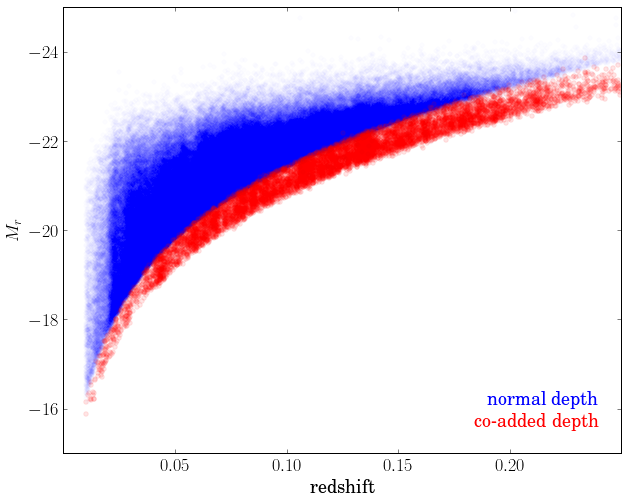

In [4]:
_ = plt.scatter(gz_data['REDSHIFT_1'][normal_depth], gz_data['PETROMAG_MR'][normal_depth]
                ,alpha=0.01,color='b',label='normal depth')

_ = plt.scatter(gz_data['REDSHIFT_1'][normal_depth == False], gz_data['PETROMAG_MR'][normal_depth == False]
                ,alpha=0.1,color='r',label='co-added depth')

plt.text(0.24,-16,'normal depth',ha='right',va='bottom',color='b')
plt.text(0.24,-15.5,'co-added depth',ha='right',va='bottom',color='r')

plt.axis((0,0.25,-15,-25))
plt.xlabel('redshift')
plt.ylabel(r'$M_r$')

# Match the data 
### 1) NASA Sloan Atlas

In [5]:
import sys
sys.path.append('../../astro_codes/')
#------------------------------------
import volume_limiting
from mass_limiting import get_mass_limit, baldry_equation
import combining_catalogues
import mass_limiting

In [6]:
matches = combining_catalogues.match_sky_restricted(gz_data,nsa_data,1,0.01
                                                    ,['ra_1','dec_1','REDSHIFT_1'],['RACAT','DECCAT','Z'])
# 1" match ^
nsa_matched = combining_catalogues.make_matched_catalogue(gz_data,nsa_data,matches)

248883 galaxies in the reference catalogue
145155 galaxies in the match catalogue
---> 145155 matches in total
---> 65422 unique matches of < 1 arcsec
---> 65349 unique matches of delta-z < 0.01


### 2) Chang+15 WISE data

In [7]:
# Load the WISE data:
chang_in = Table.read('../../fits/Chang_15/sw_input.fits')
chang_out = Table.read('../../fits/Chang_15/sw_output.fits')

In [9]:
def print_sample_size(mask,name):
    y = np.sum(mask)
    t = len(mask)
    print(name + ': {}/{} galaxies ({}%)'.format(y,t,np.round(100*y/t,decimals=1)))
#---------------------------

single_detection = chang_out['flag_w'] == 1
print_sample_size(single_detection,'Single optical')

ok_mass = (chang_out['flag_w1'] == 1) | (chang_out['flag_w2'] == 1)
print_sample_size(ok_mass,'Good W1/2 detection')

ok_wise = (single_detection) & (ok_mass)
print_sample_size(ok_wise,'Good overall detection')

chang_in_ok, chang_out_ok = [c[ok_wise] for c in [chang_in,chang_out]]

Single optical: 770900/858365 galaxies (89.8%)
Good W1/2 detection: 846433/858365 galaxies (98.6%)
Good overall detection: 770897/858365 galaxies (89.8%)


In [10]:
chang_matches = combining_catalogues.match_sky_restricted(gz_data,chang_in_ok,max_separation=6,max_dz=0.1,
                                                          reference_xyz=['RA', 'DEC', 'REDSHIFT_1'],
                                                          match_xyz=['ra', 'dec', 'redshift'])
# 6" match ^ (PSF of W1-3 is 6-7")

chang_in_matched = combining_catalogues.make_matched_catalogue(gz_data,chang_in_ok,chang_matches)
chang_out_matched = combining_catalogues.make_matched_catalogue(gz_data,chang_out_ok,chang_matches)

248883 galaxies in the reference catalogue
770897 galaxies in the match catalogue
---> 770897 matches in total
---> 193211 unique matches of < 6 arcsec
---> 193146 unique matches of delta-z < 0.1


### Check the corection for the $r$-band magnitudes

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


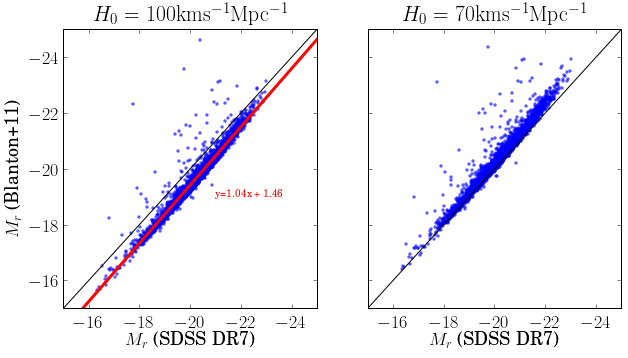

In [11]:
from scipy.optimize import curve_fit

def linear(x,m,c):
    return  m*x + c

def plot_subset(x,y,color='k',alpha=0.75,s=6,N=100,rasterized=True,zorder=0,label=None):
    np.random.seed(0)
    subset = np.append(np.ones(N),np.zeros(len(y)-N)).astype(bool) # select only N galaxies
    np.random.shuffle(subset)
    _ = plt.scatter(x[subset],y[subset],color=color,alpha=alpha,s=s,
                    zorder=zorder,rasterized=rasterized,label=label)
    return None

mask = nsa_matched['mask']

fig, axarr = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
plt.sca(axarr[0])

x = gz_data['PETROMAG_MR'][mask]
y = nsa_matched['ABSMAG'][:,4][mask]
xy = np.array([x,y]).T
plot_subset(x,y,color='b',N=3000,alpha=0.5)
plt.plot([-25,-15],[-25,-15],'k')
plt.title('$H_0 = 100 \mathrm{kms^{-1}Mpc^{-1}}$')
plt.xlabel('$M_r$ (SDSS DR7)')
plt.ylabel('$M_r$ (Blanton+11)')

Mr_fit_paramaters, _ = curve_fit(linear,xy[:,0],xy[:,1])

x_guide = np.linspace(-15,-25,20)
_ = plt.plot(x_guide,linear(x_guide,*Mr_fit_paramaters),'r',lw=3)

plt.text(-21,-19,'y={}x + {}'.format(np.round(Mr_fit_paramaters[0],decimals=2),
                                     np.round(Mr_fit_paramaters[1],decimals=2)),
        color='r',size=10)

plt.sca(axarr[1])
y = nsa_matched['M_corrected'][:,4][mask]
plot_subset(x,y,color='b',N=3000,alpha=0.5)
plt.plot([-25,-15],[-25,-15],'k')
plt.xlabel('$M_r$ (SDSS DR7)')
plt.title('$H_0 = 70 \mathrm{kms^{-1}Mpc^{-1}}$')
_ = plt.axis((-15,-25,-15,-25))

# Now create the samples

In [12]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) # 737 cosmology

def mag_to_Mag(mag,z):
    D = cosmo.luminosity_distance(z).to(u.pc)
    Mag = mag - 5*(np.log10(D.value)-1)
    return Mag

# Guideline for absolute and apparent magnitudes:
z_guide = np.linspace(0,0.06,1000)
M_guide = mag_to_Mag(17,z_guide)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


## 1) Luminosity-limited sample:

Has WISE detection: 48203/248883 galaxies (19.4%)
z-limited: 45031/248883 galaxies (18.1%)
lum.-limited: 30192/248883 galaxies (12.1%)
M_r limit = -19.94933581259604


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


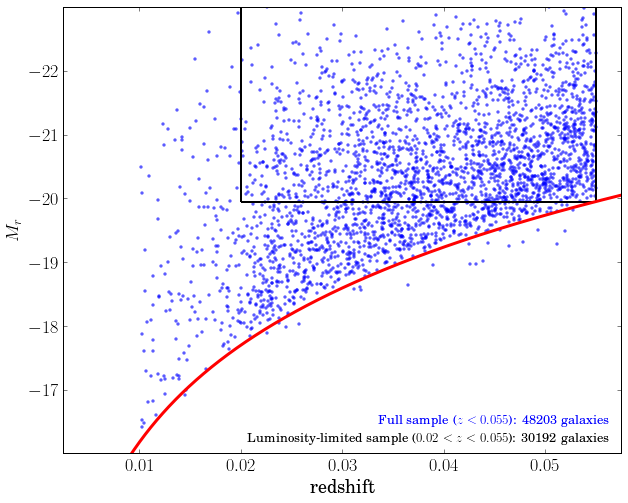

In [14]:
xlims = (0.0025,0.0575)
ylims = (-16,-23)
# Preamble
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
_ = plt.axis((xlims[0],xlims[1],ylims[0],ylims[1]))
plt.xlabel('redshift')
plt.ylabel('$M_r$')

mag_limit = volume_limiting.get_sample_limits(0.055,17)

x = nsa_matched['Z'][mask]
y = nsa_matched['M_corrected'][:,4][mask]

plot_subset(x,y,color='b',N=3000,alpha=0.5)
plt.vlines(0.02,ylims[1],mag_limit,lw=2,zorder=1)
plt.hlines(mag_limit,0.02,0.055,lw=2,zorder=1)
plt.vlines(0.055,ylims[1],mag_limit,lw=2,zorder=1)
_ = plt.plot(z_guide,M_guide,color='r',lw=3,zorder=1)


wise_limited = (nsa_matched['mask'] > 0.02) & (chang_in_matched['mask'])
print_sample_size(wise_limited,'Has WISE detection')
#-------
redshift_limited = (nsa_matched['Z'] > 0.02) & (chang_in_matched['mask'])
print_sample_size(redshift_limited,'z-limited')
#-------
luminosity_limited = ((nsa_matched['Z'] >= 0.02) & 
                      (nsa_matched['M_corrected'][:,4] <= mag_limit) & 
                      (chang_in_matched['mask']))
print_sample_size(luminosity_limited,'lum.-limited')
#-------

_ = plt.text(0.98,0.06,'Full sample ($z < 0.055$): {} galaxies'.format(np.sum(wise_limited)),
             transform=ax.transAxes,ha='right',va='bottom',size=13,color='b')
_ = plt.text(0.98,0.02,'Luminosity-limited sample ($0.02 < z < 0.055$): {} galaxies'.format(np.sum(luminosity_limited)),
             transform=ax.transAxes,ha='right',va='bottom',size=13)

print('M_r limit = {}'.format(mag_limit))

## 2) Now an M* limited sample
### i) Baldry+2006 data

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


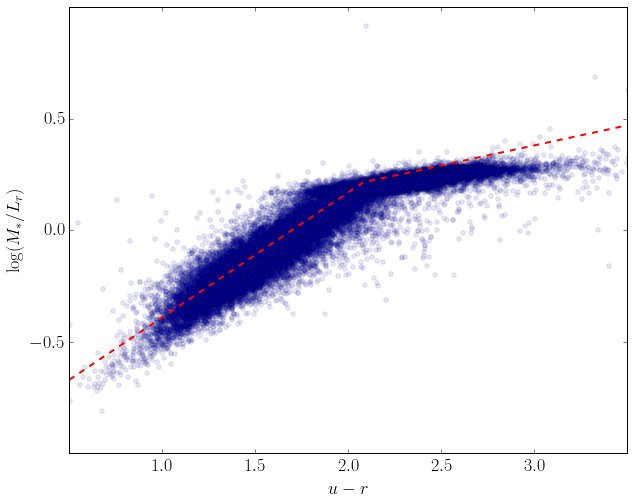

In [16]:
def Mag_to_lum(Mag,Mag_sun=4.75):
    L = 10**((Mag_sun-Mag)/2.5)
    return L

u_r = gz_data[redshift_limited]['PETROMAG_MU'] - gz_data[redshift_limited]['PETROMAG_MR'] # colour
ML = 10**(gz_data[redshift_limited]['LOGMSTAR_BALDRY06'])/Mag_to_lum(gz_data[redshift_limited]['PETROMAG_MR'])
logML = np.log10(ML) # mass-to-light ratio

_ = plt.scatter(u_r,logML,alpha=0.1)
_ = plt.axis((0.5,3.5,-1,1))
plt.xlabel('$u-r$')
plt.ylabel('$\log(M_*/L_r)$')

x_guide = np.linspace(0.5,3.5,1000)
y_baldry = []
for x in x_guide:
    y_baldry.append(baldry_equation(x))
y_baldry = np.array(y_baldry)
_ = plt.plot(x_guide,y_baldry,'r--',lw=2)
# red line = line suggested by Baldry+06

### ii) Attempt to recreate this for our dataset

In [17]:
mask = nsa_matched['mask']
print_sample_size(mask,'NSA matched')

mask = (nsa_matched['mask']) & (chang_in_matched['mask'])
print_sample_size(mask,'NSA + WISE matched')

NSA matched: 65349/248883 galaxies (26.3%)
NSA + WISE matched: 48203/248883 galaxies (19.4%)


In [18]:
redshift_limited = (nsa_matched['Z'] >= 0.02) & (normal_depth)
print_sample_size(redshift_limited,'z-limited')
#--------------
chang_out_zl = chang_out_matched[redshift_limited]
print_sample_size(chang_out_zl['mask'],'Has Chang mass (z-limited)')

mask = (redshift_limited) & (chang_out_matched['mask'])

z-limited: 60606/248883 galaxies (24.4%)
Has Chang mass (z-limited): 44329/60606 galaxies (73.1%)


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app


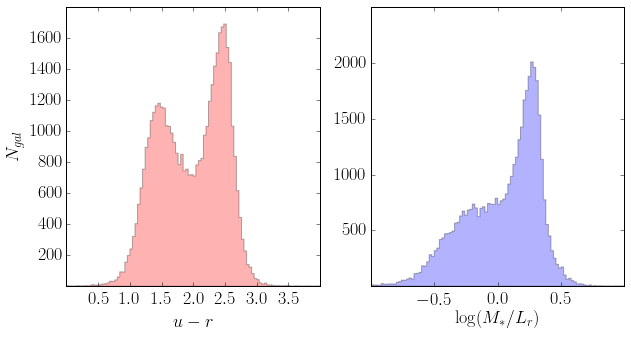

In [19]:
fig, axarr = plt.subplots(1,2,figsize=(10,5))

u_r = (nsa_matched['M_corrected'][:,2] - nsa_matched['M_corrected'][:,4])[mask]
logmass = chang_out_matched['lmass50_all'][mask]
logLr = np.log10(Mag_to_lum(nsa_matched['M_corrected'][:,4]))[mask]
logML = logmass - logLr

_ = axarr[0].hist(u_r,bins=np.linspace(0,4,101),histtype='stepfilled',color='r',alpha=0.3)
_ = axarr[1].hist(logML,bins=np.linspace(-1,1,101),histtype='stepfilled',color='b',alpha=0.3)
axarr[0].set_ylabel('$N_{gal}$')
axarr[0].set_xlabel('$u-r$')
axarr[1].set_xlabel('$\log(M_*/L_r)$')

sample_ok = ((u_r >= 0.5) & (u_r <= 3.5) 
             & (logML >= -1) & (logML <= 1))

In [20]:
from scipy.stats import binned_statistic

def plot_bins(data,i_bins,bins,color='k',alpha=0.5,xlabel=None,ylabel=None,plot=True):
    bin_lower = []
    bin_median = []
    bin_upper = []
    for b, i in enumerate(i_bins):
        select = bins == b+1
        bin_lower.append(np.percentile(data[select],16))
        bin_median.append(np.median(data[select]))
        bin_upper.append(np.percentile(data[select],84))
    bin_lower, bin_median, bin_upper = [np.array(u) for u in [bin_lower, bin_median, bin_upper]]
    if plot == True:
        _ = plt.plot(i_bins,bin_lower,linestyle='dashed',
                     color=color,lw=1.5)
        #_ = plt.plot(i_bins,bin_median,lw=3,color=color)
        _ = plt.plot(i_bins,bin_upper,linestyle='dashed',
                     color=color,lw=1.5)
    
    return bin_lower, bin_median, bin_upper

ur_bins, _, bins = binned_statistic(u_r[sample_ok],u_r[sample_ok],bins=np.linspace(0.5,3.5,21),
                                    statistic='median')

In [21]:
x = np.random.randn(100000)
y = np.random.randn(100000)

#_ = plt.scatter(x,y)
x_bins = np.linspace(-3,3,91)
y_bins = np.linspace(-3,3,91)

from palettable.colorbrewer.sequential import Greens_9, Reds_9

def heatmap(x,y,x_bins,y_bins,colormap,colorbar=True,log_scale=False,
            xlabel='x',ylabel='y',zlabel='z'):
    if log_scale == True:
        h = plt.hist2d(x,y,bins=[x_bins,y_bins],
                       norm=mpl.colors.LogNorm(),cmap=colormap)
    else:
        h = plt.hist2d(x,y,bins=[x_bins,y_bins],cmap=colormap)
    if colorbar == True:
        cbar = plt.colorbar()
        cbar.set_label(zlabel,rotation=270)
        cbar.ax.get_yaxis().labelpad = 20
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    return h

#h = heatmap(x,y,x_bins,y_bins,Greens_9.mpl_colormap)

In [22]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.grid_search import GridSearchCV

def fit_ridgeline(x,y,alphas=np.logspace(-2,2,10),gammas=np.logspace(-2, 2, 10),
                  N_folds=3,N_max=1000):
    
    np.random.seed(0)
    N = len(x)
    
    if len(x) > N_max:
        subset = np.append(np.ones(N_max),np.zeros(N-N_max)).astype(bool) # select only N galaxies
        np.random.shuffle(subset)
    else:
        subset = np.ones(N).astype(bool)
    
    x_fit = x[subset][:,np.newaxis]
    y_fit = y[subset][:,np.newaxis]
    kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=N_folds,
                      param_grid={"alpha":alphas,"gamma":gammas})
    kr = kr.fit(x_fit,y_fit)
    
    return kr

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/backends/backend_pdf.py:2264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


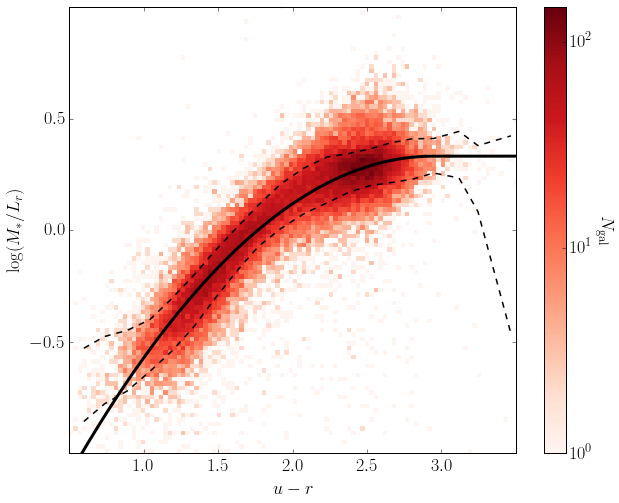

In [41]:
from scipy.optimize import curve_fit

xlims = (0.5,3.5)
ylims = (-1,1)
xlabel = '$u-r$'
ylabel = '$\log(M_*/L_r)$'
zlabel = '$N_\mathrm{gal}$'

fig = plt.figure(figsize=(10,8))
_ = plt.axis((xlims[0],xlims[1],ylims[0],ylims[1]))

_ = plot_bins(logML[sample_ok],ur_bins,bins,color='k')
#_ = plt.scatter(u_r[sample_ok],logML[sample_ok],alpha=0.1,color='g')
x = u_r[sample_ok]
y = logML[sample_ok]
x_bins = np.linspace(xlims[0],xlims[1],101)
y_bins = np.linspace(ylims[0],ylims[1],101)
_ = heatmap(x,y,x_bins,y_bins,Reds_9.mpl_colormap,log_scale=True,
            xlabel=xlabel,ylabel=ylabel,zlabel=zlabel)

from scipy.optimize import curve_fit
p,_ = curve_fit(func,x,y)

def func(x,a,b,c):
    return a*x**2 + b*x + c

def func_modified(x,a,b,c):
    x_max = -b/(2*a)
    y = np.zeros(len(x))
    y[x > x_max] = a*x_max**2 + b*x_max + c
    y[x <= x_max] = a*x[x <= x_max]**2 + b*x[x <= x_max] + c
    return y

def single_value_func(x,a=p[0],b=p[1],c=p[2]):
    x_max = -b/(2*a)
    if x > x_max:
        return a*x_max**2 + b*x_max + c
    else:
        return a*x**2 + b*x + c

func_max = -p[1]/(2*p[0])
x_guide = np.linspace(xlims[0],xlims[1],1000)
y_guide = func_modified(x_guide,*p)
_ = plt.plot(x_guide,y_guide,'k-',lw=3)

plt.savefig('output_figures/colour_vs_ML.pdf')

Median scatter:0.064


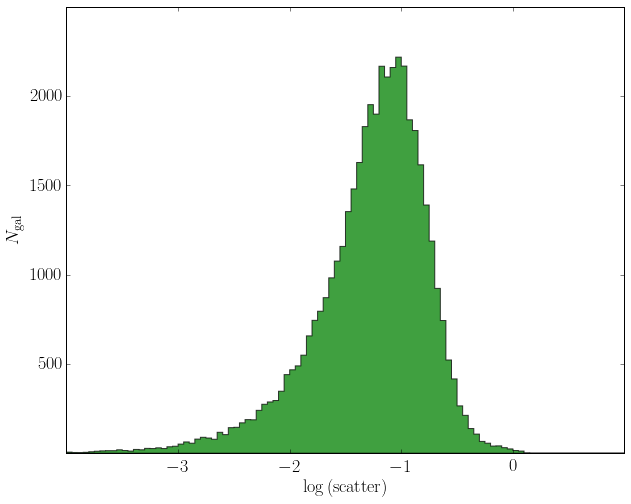

In [26]:
scatter = y - func_modified(x,*p)
logscatter = np.log10(np.abs(scatter))
_ = plt.hist(logscatter,bins=np.linspace(-4,1,101),
             histtype='stepfilled',color='green',alpha=0.75)
print('Median scatter:{}'.format(np.round(10**(np.median(logscatter)),decimals=3)))
plt.xlabel('$\log{\mathrm{(scatter)}}$')
plt.ylabel('$N_\mathrm{gal}$')

In [27]:
has_mass = chang_out_matched['mask']
mask =  (has_mass) & (nsa_matched['mask'])
print_sample_size(mask,'WISE+z-limited')
nsa_w_mass = nsa_matched[mask]

nsa_w_mass['M_u'] = nsa_w_mass['M_corrected'][:,2]
nsa_w_mass['M_r'] = nsa_w_mass['M_corrected'][:,4]
chang_out_w_mass = chang_out_matched[mask]

mass_limit_max = get_mass_limit(nsa_w_mass,z_limit=0.055,mag_limit=17,mass_equation=single_value_func,
                                column_names=['Z','M_r'],colours=['M_u','M_r'])

WISE+z-limited: 48203/248883 galaxies (19.4%)


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


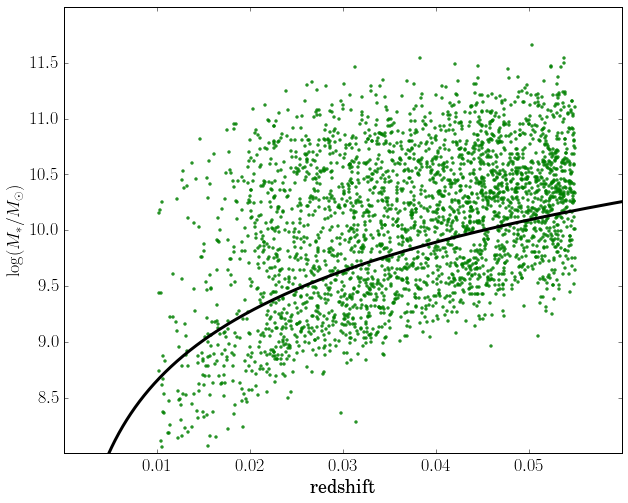

In [30]:
# calculate the mass limit for a given redshift limit

z_values = np.linspace(0.021,0.055,101)
mass_limits = []

for z in z_values:
    mass_limit = get_mass_limit(nsa_w_mass,z_limit=z,mag_limit=17,mass_equation=single_value_func,
                                column_names=['Z','M_r'],colours=['M_u','M_r'])
    mass_limits.append(mass_limit)  
mass_limits = np.array(mass_limits)

def log_function(x,a,b):
    return a*np.log10(x) + b

p_mass_limit, _ = curve_fit(log_function,z_values,mass_limits)

x = nsa_w_mass['Z']
y = chang_out_w_mass['lmass50_all']

plot_subset(x,y,color='g',N=3000)
plt.axis((0,0.06,8,12))
x_guide = np.linspace(0,0.06,1000)
_ = plt.plot(x_guide,log_function(x_guide,*p_mass_limit),color='k',lw=3)
plt.xlabel('redshift')
plt.ylabel('$\log (M_*/M_\odot)$')

In [31]:
print(mag_limit,mass_limit)

-19.94933581259604 10.178692282909745


## Now define a table with all of the required masks:
### Various mass/lum. limits

In [42]:
samples = Table()
samples['in_nsa'] = nsa_matched['mask']
samples['in_wise'] = chang_out_matched['mask']
samples['in_redshift'] = (nsa_matched['Z'] >= 0.02) & (nsa_matched['Z'] <= 0.055) & (samples['in_wise'])
samples['in_lum_limit'] = (samples['in_redshift']) & (nsa_matched['M_corrected'][:,4] <= mag_limit)
samples['in_mass_limit'] = (samples['in_lum_limit']) & (chang_out_matched['lmass50_all'] >= mass_limit)
samples['in_vmax_limit'] = (samples['in_redshift']) & (chang_out_matched['lmass50_all'] >= log_function(nsa_matched['Z'],*p_mass_limit))

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater_equal


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


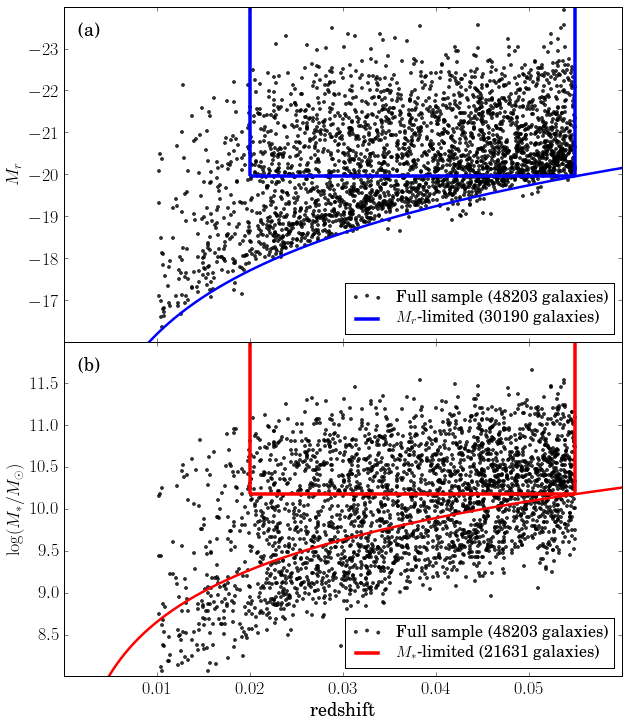

In [44]:
fig, axarr = plt.subplots(2,1,figsize=(10,12),sharex=True)
axarr[1].set_xlabel('redshift')
plt.subplots_adjust(hspace=0,wspace=0)

z_guide = np.linspace(0,0.06,1000)
M_guide = mag_to_Mag(17,z_guide)
mass_guide = log_function(z_guide,*p_mass_limit)

def box(xlimits,ylimit,color='k',linestyle='solid',linewidth=2,zorder=0,
        label=None):

    xmin, xmax, ymin, ymax = plt.axis()
    plt.vlines(xlimits[0],ylimit,ymax,zorder=zorder,label=label,
               color=color,linestyle=linestyle,linewidth=linewidth)
    plt.hlines(ylimit,xlimits[0],xlimits[1],zorder=zorder,
               color=color,linestyle=linestyle,linewidth=linewidth)
    plt.vlines(xlimits[1],ylimit,ymax,zorder=zorder,
               color=color,linestyle=linestyle,linewidth=linewidth)
    return None

lw = 3.5
lw2 = 2.5

plt.sca(axarr[0])
x = nsa_w_mass['Z']
y = nsa_w_mass['M_corrected'][:,4]
plot_subset(x,y,N=3000,color='k',s=8,zorder=-1,
            label='Full sample ({} galaxies)'.format(np.sum(samples['in_nsa']*samples['in_wise'])))
plt.plot(z_guide,M_guide,lw=lw2,color='b',zorder=0)
_ = plt.axis((0,0.06,-16,-24))
box([0.02,0.055],mag_limit,color='b',linewidth=lw,
    label='$M_r$-limited ({} galaxies)'.format(np.sum(samples['in_lum_limit']*samples['in_wise'])))
plt.ylabel('$M_r$')
plt.legend(loc='lower right',fontsize=16)
plt.text(0.025,0.95,'(a)',
         transform=axarr[0].transAxes,ha='left',va='top')

plt.sca(axarr[1])
y = chang_out_w_mass['lmass50_all']
plot_subset(x,y,N=3000,color='k',s=8,zorder=-1,
            label='Full sample ({} galaxies)'.format(np.sum(samples['in_nsa']*samples['in_wise'])))
plt.plot(z_guide,mass_guide,lw=lw2,color='r',zorder=0)
box([0.02,0.055],mass_limit,color='r',linewidth=lw,
    label='$M_*$-limited ({} galaxies)'.format(np.sum(samples['in_mass_limit'])))
plt.ylabel('$\log(M_*/M_\odot)$')
plt.legend(loc='lower right',fontsize=16)
plt.text(0.025,0.95,'(b)',
         transform=axarr[1].transAxes,ha='left',va='top')
_ = plt.axis((0,0.06,8,12))

plt.savefig('output_figures/samples.pdf')

### Get the spirals

In [45]:
# get spirals:
import make_dictionaries
questions = make_dictionaries.questions

p_spiral = (gz_data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']*
            gz_data['t02_edgeon_a05_no_debiased_rh']*
            gz_data['t04_spiral_a08_spiral_debiased_rh'])

N_spiral = (gz_data['t04_spiral_a08_spiral_count'] - 
            gz_data['t11_arms_number_a37_cant_tell_count'])

p_ok = p_spiral > 0.5
N_ok = N_spiral >= 5
in_spiral = (p_ok) & (N_ok)

question = 't11_arms_number'
answers = questions[question]['answers'][:-1]
answer_array = np.array([gz_data[question + '_' + A + '_debiased_rh'].data for A in answers]).T
m = np.argmax(answer_array,axis=1)

samples['in_spiral'] = in_spiral
samples['m'] = m

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater


In [46]:
# check axial ratios
ba_data = Table.read('../../fits/Axial_ratios/matched_axial_ratios.fits')
print('+ loaded axial data.')

axial_ok = ba_data['isoB_g']/ba_data['isoA_g'] > 0.4
samples['axial_ok'] = axial_ok

+ loaded axial data.


In [47]:
print('full sample: {} ({} spirals)'.format(np.sum((samples['in_wise']) & (samples['in_nsa'])),
                                            np.sum((samples['in_wise']) & (samples['in_nsa']) 
                                                   & (samples['in_spiral']) & (samples['axial_ok']))))

for s in samples.colnames[2:-2]:
    print('{}: {} galaxies ({} spirals)'.format(s, np.sum(samples[s]),
                                                np.sum((samples[s]) 
                                                       & (samples['in_spiral'])
                                                       & (samples['axial_ok']))))

full sample: 48203 (9916 spirals)
in_redshift: 45029 galaxies (9336 spirals)
in_lum_limit: 30190 galaxies (8156 spirals)
in_mass_limit: 21631 galaxies (4997 spirals)
in_vmax_limit: 29703 galaxies (6610 spirals)
in_spiral: 50857 galaxies (48015 spirals)


### Finally, save the required data for later use:

In [49]:
gz_data.write('matched_fits/gz_data.fits')
nsa_matched.write('matched_fits/nsa_matched.fits')
chang_out_matched.write('matched_fits/chang_out_matched.fits')
chang_in_matched.write('matched_fits/chang_in_matched.fits')
samples.write('matched_fits/samples.fits')
ba_data.write('matched_fits/ba_matched.fits')

In [ ]:
# For each galaxy, calculate its 'mass weighting'

def inverse_mass_function(mass,mass_error,a,b):
    zmax = 10**((mass-b)/a)
    zmax_error = (zmax/a)*mass_error
    return zmax, zmax_error

def get_mass_weighting(mass,mass_error,max_z=0.055,min_z=0.02):
    zmax,z_error = inverse_mass_function(mass,mass_error,*mass_limit_paramaters)
    zmax[mass < 0] = -999
    zmax[zmax >= max_z] = max_z
    mass_weighting = (1/(zmax**3-min_z**3))/(1/(max_z**3-min_z**3))
    return zmax, mass_weighting, z_error

In [ ]:
masses = chang_out_matched[vmax_limited]['lmass50_all']
mass_errors = (chang_out_matched[vmax_limited]['lmass84_all']-chang_out_matched[vmax_limited]['lmass16_all'])/2

zmax, mass_weighting, z_error = get_mass_weighting(masses, mass_errors)
z = matched_nsa[vmax_limited]['Z']

In [ ]:
bad_z = 3*z_error > (zmax-0.02)

_ = plt.hist(np.log10(mass_weighting),histtype='stepfilled',
             color='y',alpha=0.5,bins=np.linspace(0,2.2,45))

_ = plt.hist(np.log10(mass_weighting[bad_z]),histtype='stepfilled',
             color='k',alpha=0.5,bins=np.linspace(0,2.2,45))

plt.yscale('log')
plt.xlabel('$\log\mathrm{(weight)}$')
plt.ylabel('$N_\mathrm{gal}$')

In [ ]:
# cross-match comparison w. NSA limited sample

chang_in_zl, chang_out_zl, nsa_data_zl, gz_data_zl = [d[redshift_limited] for d in [chang_in_matched, 
                                                                                    chang_out_matched, 
                                                                                    matched_nsa,
                                                                                    gz_data]]
print_sample_size(chang_out_zl['mask'],'Has Chang mass (z-limited)')

chang_in_vl, chang_out_vl, nsa_data_vl, gz_data_vl = [d[luminosity_limited] for d in [chang_in_matched, 
                                                                                      chang_out_matched, 
                                                                                      matched_nsa,
                                                                                      gz_data]]
print_sample_size(chang_out_vl['mask'],'Has Chang mass (lum.-limited)')